In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from selenium import webdriver as wb
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import datetime
import time
from wordcloud import WordCloud

## 비트코인과 안정자산, 위험자산의 상관관계 분석
- 데이터 산출 기간
    - 제도 편입 전 : 2014.09.01 ~ 2019.12.31
    - 제도 편입 후 : 2021.01.01 ~ 2024.06.06
- 안전자산 비교군 : 금, 달러
- 위험자산 비교군 : 원유
- 데이터 출처 : Yahoo Finance

In [2]:
# 기간
start_date = "2021-01-01"
end_date = "2024-06-06"
# 비트코인과 안전자산(금)의 변동성 집중 기간 리스트
news_date_list = ["2022.03.28", "2022.11.14", "2023.04.03", "2024.01.08", "2024.03.25", "2024.05.06"]

# 종목
bitcoin = "BTC-USD"
gold = "GC=F"
usd = "EURUSD=X"
wti = "CL=F"

# 일간 티커 데이터 수집
def ticker_data(tk_name, ds, de) : 
    result = yf.download(tk_name, ds, de)
    result["change"] = result["Adj Close"].diff()
    result["daily_return"] = result["Adj Close"].pct_change()*100
    result = result.dropna() # NaN 포함 행 삭제
    return result

# 주간 티커 데이터 수집
def ticker_data_wk(tk_name, ds, de) : 
    result = yf.download(tk_name, ds, de, interval = "1wk")
    result["weekly_return"] = result["Adj Close"].pct_change()*100
    result = result.dropna()
    return result

# 일별 수정 종가 (Adj Close) 추출 함수
def daily_adj_close(tk_name, ds, de) :
    result = yf.download(tk_name, ds, de)
    return result["Adj Close"]

# 일별 수익률 (daily_return) 추출 함수
def daily_return_rate(tk_name, ds, de) :
    result = ticker_data(tk_name, ds, de)
    return result["daily_return"]

# 주간 수익률 (weekly_return) 추출 함수
def weekly_return_rate(tk_name, ds, de) :
    result = ticker_data_wk(tk_name, ds, de)
    return result["weekly_return"]

# 비트코인과 티커 간의 상관성 산출
def corr_bit(tk_name, ds, de) :
    result = weekly_return_rate(bitcoin, ds, de) / weekly_return_rate(tk_name, ds, de)
    result = result.dropna()
    return result

# 계산식 for 선형 회귀
def lin_cal(tk_name, ds, de) :
    tk2024 = ticker_data(tk_name, ds, de) # 제도 편입 후 기간의 티커 데이터 수집
    std2024 = tk2024[tk2024.index == "2024-06-04"] # 기준이 되는 날짜의 행 추출
    std2024 = std2024["Adj Close"].values[0] # 해당 행의 수정 종가
    result = (ticker_data(tk_name, ds, de)["Adj Close"] / std2024) * 100 # 티커의 수정 종가 컬럼과 연산
    return result

# 티커 생성 시 호출 함수
def ticker_call(tk_name, ds, de) :
    result = ticker_data(tk_name, ds, de) # 일간 티커 데이터 수집
    result["chg_rat_exp_2024"] = lin_cal(tk_name, ds, de) # 선형 회귀 산출을 위해 연산된 컬럼 추가
    return result

# 선형 회귀 계수 산출
def lin_data(tk_name, ds, de) :
    bit_col = ticker_call(bitcoin, ds, de)["chg_rat_exp_2024"]
    tk_col = ticker_call(tk_name, ds, de)["chg_rat_exp_2024"]
    
    result = pd.concat([bit_col, tk_col], axis = 1)
    result.columns = ["bit", "tk"]
    result = result.dropna()
    
    model = stats.linregress(result["bit"], result["tk"]) # 선형 회귀 계수 객체 생성
    dict_lin = {
        "slope" : model.slope,
        "intercept" : model.intercept,
        "rvalue" : model.rvalue,
        "pvalue" : model.pvalue,
        "stderr" : model.stderr,
        "intercept_stderr" : model.intercept_stderr
    }
    result_lin = pd.DataFrame(list(dict_lin.values()), index = dict_lin.keys())
    return result_lin

In [3]:
# 비트코인의 일간 티커 데이터 수집
bit_ticker = ticker_call(bitcoin, start_date, end_date)
bit_ticker

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,change,daily_return,chg_rat_exp_2024
Date,,,,,,,,,
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,2753.115234,9.372578,45.526831
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,654.755859,2.038007,46.454671
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,-810.109375,-2.471200,45.306683
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,2020.515625,6.319658,48.169911
2021-01-06,34013.613281,36879.699219,33514.035156,36824.363281,36824.363281,75289433811,2831.933594,8.331071,52.182980
...,...,...,...,...,...,...,...,...,...
2024-06-01,67489.609375,67839.765625,67386.195312,67706.937500,67706.937500,11641495604,215.523438,0.319335,95.945985
2024-06-02,67710.273438,68409.164062,67315.523438,67751.601562,67751.601562,17110588415,44.664062,0.065967,96.009277
2024-06-03,67753.898438,70230.820312,67589.835938,68804.781250,68804.781250,32401285324,1053.179688,1.554472,97.501714


In [4]:
# 비교군 일간 티커 데이터 수집
ticker = ticker_call(usd, start_date, end_date)
ticker

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,change,daily_return,chg_rat_exp_2024
Date,,,,,,,,,
2021-01-04,1.224905,1.230999,1.217137,1.225070,1.225070,0,0.007043,0.578221,112.315621
2021-01-05,1.225295,1.229483,1.224995,1.225160,1.225160,0,0.000090,0.007356,112.323884
2021-01-06,1.229861,1.235025,1.226693,1.230027,1.230027,0,0.004868,0.397299,112.770146
2021-01-07,1.233776,1.234568,1.224665,1.234111,1.234111,0,0.004083,0.331976,113.144516
2021-01-08,1.226873,1.228215,1.221493,1.227144,1.227144,0,-0.006966,-0.564484,112.505833
...,...,...,...,...,...,...,...,...,...
2024-05-30,1.080182,1.084599,1.078900,1.080182,1.080182,0,-0.005005,-0.461233,99.032162
2024-05-31,1.083541,1.088258,1.081163,1.083541,1.083541,0,0.003359,0.310973,99.340126
2024-06-03,1.085305,1.089087,1.082802,1.085305,1.085305,0,0.001764,0.162794,99.501846


## 통계적 수치를 위한 단순 선형 회귀
- 기울기 (Slope)
- 절편 (Intercept)
- 상관계수 (R-value)
    - 1 : 완벽한 양의 상관관계. 두 변수는 완벽하게 비례해서 증가
    - 0.7 ~ 0.9 : 강한 양의 상관관계
    - 0.5 ~ 0.7 : 중간 정도의 양의 상관관계
    - 0.3 ~ 0.5 : 약한 양의 상관관계
    - 0 : 상관관계 없음
    - -0.3 ~ -0.5 : 약한 음의 상관관계
    - -0.5 ~ -0.7 : 중간 정도의 음의 상관관계
    - -0.7 ~ -0.9 : 강한 음의 상관관계
    - -1 : 완벽한 음의 상관관계. 두 변수는 완벽하게 반비례해서 변화
- 유의확률 (P-value) : 일반적으로 P-value가 0.05보다 작으면 결과가 통계적으로 유의미하다고 판단
- 표준오차 (Standard Error)
- 절편의 표준오차 (Intercept Standard Error)

#### ✅ 안전/안정적 자산 비교군 추가
- iShares 20+ Year Treasury Bond ETF : 미국 국채 ETF, 미국의 장기 국채에 투자하여 안정적인 수익을 추구, 종목코드 "TLT"
- iShares iBoxx $ Investment Grade Corporate Bond ETF : 미국 투자등급 회사채에 투자하는 ETF, 종목코드 "LQD"
- Duke Energy : 전력 및 천연가스 서비스를 제공하는 유틸리티 부문 공공 주식, 종목코드 "DUK"
- Gold ETF : 나스닥 100 지수를 추종하는 ETF, 금 가격에 연동되어 금에 투자하는 효과를 제공하는 ETF, 종목코드 "GLD"

#### ✅ 위험 자산 비교군 추가
- Brent oil :  종목코드 "BZ=F"
- Tesla :  종목코드 "TSLA"
- Dow Jones Industrial Average : 다우존스 산업 평균 지수, 주로 대형 기업들로 구성되어 있어, 시장 전체보다는 주로 대형주 및 산업을 대표, 종목코드 "^DJI"
- Nasdaq-100 Index : 나스닥 100 지수를 추종하는 ETF, 종목코드 "QQQ"
- Emerging Markets ETF : 중국, 인도, 브라질 등 신흥 시장의 주식에 투자하는 ETF, 종목코드 "EEM"

In [5]:
# 선형 회귀 계수 산출
# 안전 자산, 안정적 자산
gold_lin = lin_data(gold, start_date, end_date)
tlt_lin = lin_data("TLT", start_date, end_date)
lqd_lin = lin_data("LQD", start_date, end_date)
duk_lin = lin_data("DUK", start_date, end_date)
gold_etf_lin = lin_data("GLD", start_date, end_date)
usd_lin = lin_data(usd, start_date, end_date)
# 위험 자산
wti_lin = lin_data(wti, start_date, end_date)
brent_lin = lin_data("BZ=F", start_date, end_date)
tsla_lin = lin_data("TSLA", start_date, end_date)
dj_lin = lin_data("^DJI", start_date, end_date)
nasdq_lin = lin_data("QQQ", start_date, end_date)
em_etf_lin = lin_data("EEM", start_date, end_date)

df_lin = pd.concat([gold_lin, tlt_lin, lqd_lin, duk_lin, gold_etf_lin, usd_lin, wti_lin, brent_lin, tsla_lin, dj_lin, nasdq_lin, em_etf_lin], axis = 1)
df_lin.columns = ["Gold", "US ETF", "US CP ETF", "Duke", "Gold ETF", "EUR/USD", "WTI", "Brent", "Tesla", "Dow Jones", "Nasdaq-100 Index", "Emerging Markets ETF"]
df_lin

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,Gold,US ETF,US CP ETF,Duke,Gold ETF,EUR/USD,WTI,Brent,Tesla,Dow Jones,Nasdaq-100 Index,Emerging Markets ETF
slope,1.425926e-01,2.921022e-01,2.141553e-01,-0.001993,1.435703e-01,1.379034e-01,-2.170310e-01,-2.402732e-01,0.210197,1.835888e-01,3.725985e-01,3.444553e-01
intercept,7.359487e+01,1.032669e+02,8.941708e+01,87.917008,7.405801e+01,9.373964e+01,1.206953e+02,1.212636e+02,125.547873,7.877989e+01,5.594804e+01,8.292011e+01
rvalue,4.476186e-01,3.085052e-01,5.633886e-01,-0.007152,4.646572e-01,5.072604e-01,-2.473752e-01,-2.858009e-01,0.135679,6.603623e-01,7.224767e-01,5.622671e-01
pvalue,1.187240e-43,2.028845e-20,3.456775e-73,0.834113,2.818245e-47,1.459521e-59,1.800018e-13,1.251743e-17,0.000066,7.717484e-109,1.150899e-139,7.652674e-73
stderr,9.719387e-03,3.074757e-02,1.072156e-02,0.009514,9.340546e-03,7.848884e-03,2.900393e-02,2.750392e-02,0.052401,7.127374e-03,1.217307e-02,1.729533e-02
intercept_stderr,5.599123e-01,1.771463e+00,6.177025e-01,0.548108,5.381378e-01,4.517490e-01,1.670852e+00,1.583775e+00,3.018965,4.106301e-01,7.013281e-01,9.964375e-01


## 데이터 시각화

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


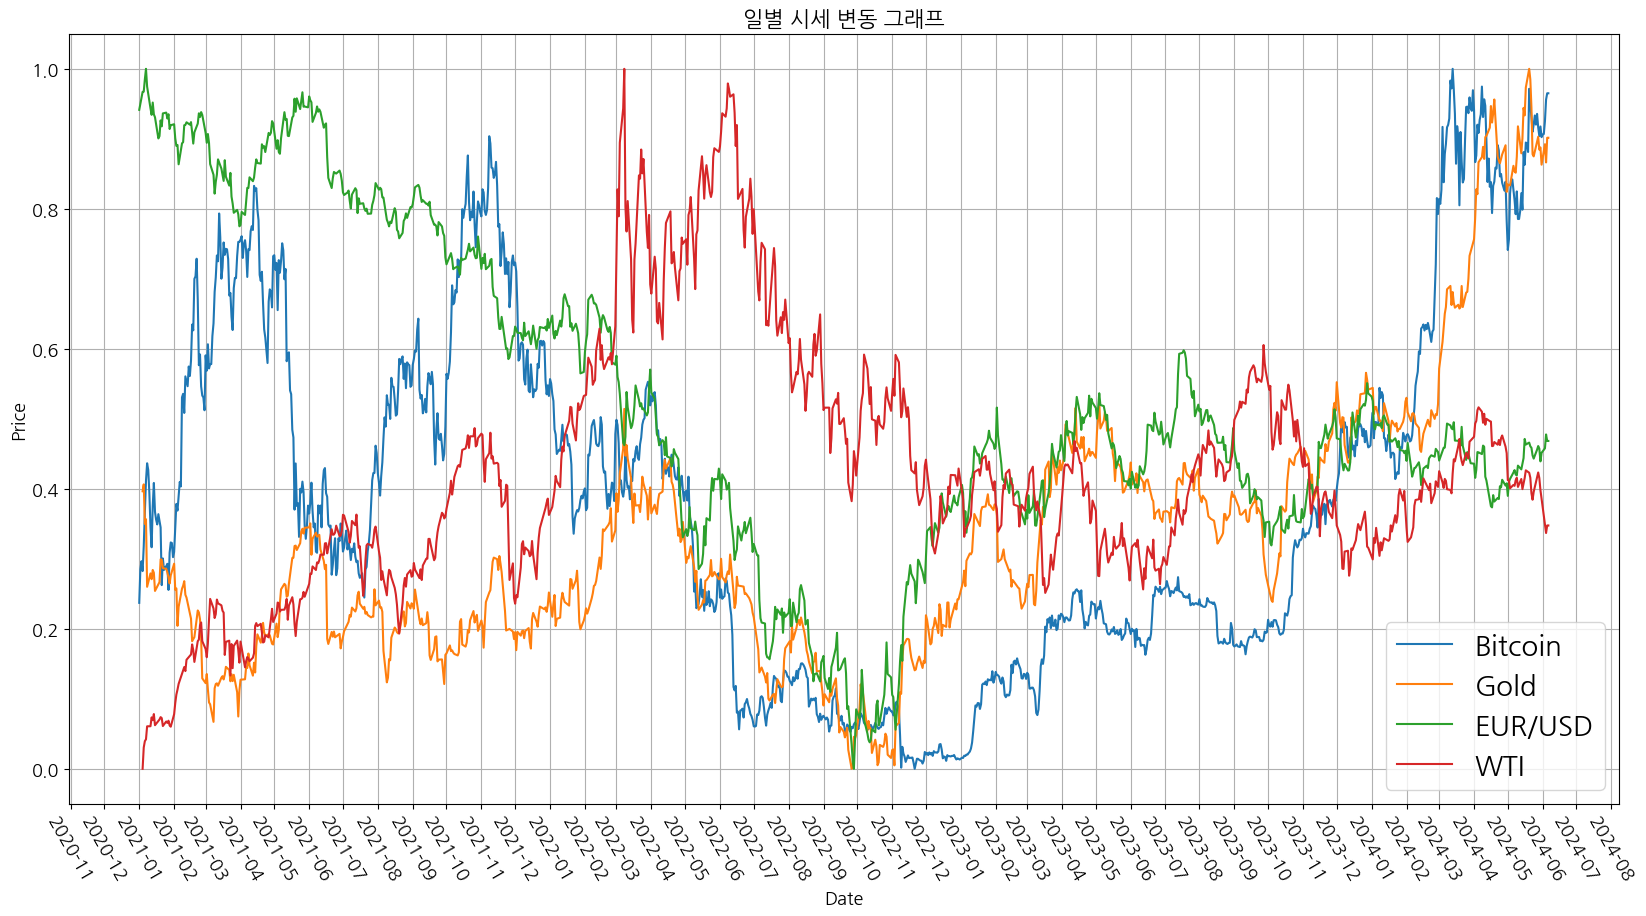

In [6]:
# daily price change graph
scaler = MinMaxScaler()
all_dates = pd.date_range(start = start_date, end = end_date, freq = "D")

# interpolate() : 결측치 보간
y1_series = daily_adj_close(bitcoin, start_date, end_date).reindex(all_dates).interpolate()
y2_series = daily_adj_close(gold, start_date, end_date).reindex(all_dates).interpolate()
y3_series = daily_adj_close(usd, start_date, end_date).reindex(all_dates).interpolate()
y4_series = daily_adj_close(wti, start_date, end_date).reindex(all_dates).interpolate()

# 스케일링할 데이터 모양 변경
y1 = y1_series.values.reshape(-1, 1)
y2 = y2_series.values.reshape(-1, 1)
y3 = y3_series.values.reshape(-1, 1)
y4 = y4_series.values.reshape(-1, 1)

dates = y1_series.index # 날짜 추출

plt.rc("font", family="NanumGothic", size=13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize=(20, 10))
plt.plot(dates, scaler.fit_transform(y1), label = "Bitcoin")
plt.plot(dates, scaler.fit_transform(y2), label = "Gold")
plt.plot(dates, scaler.fit_transform(y3), label = "EUR/USD")
plt.plot(dates, scaler.fit_transform(y4), label = "WTI")
plt.legend(loc="best", prop={"size": 20})
plt.xlabel("Date")
plt.ylabel("Price")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=300)
plt.grid(True)
plt.title("일별 시세 변동 그래프")
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


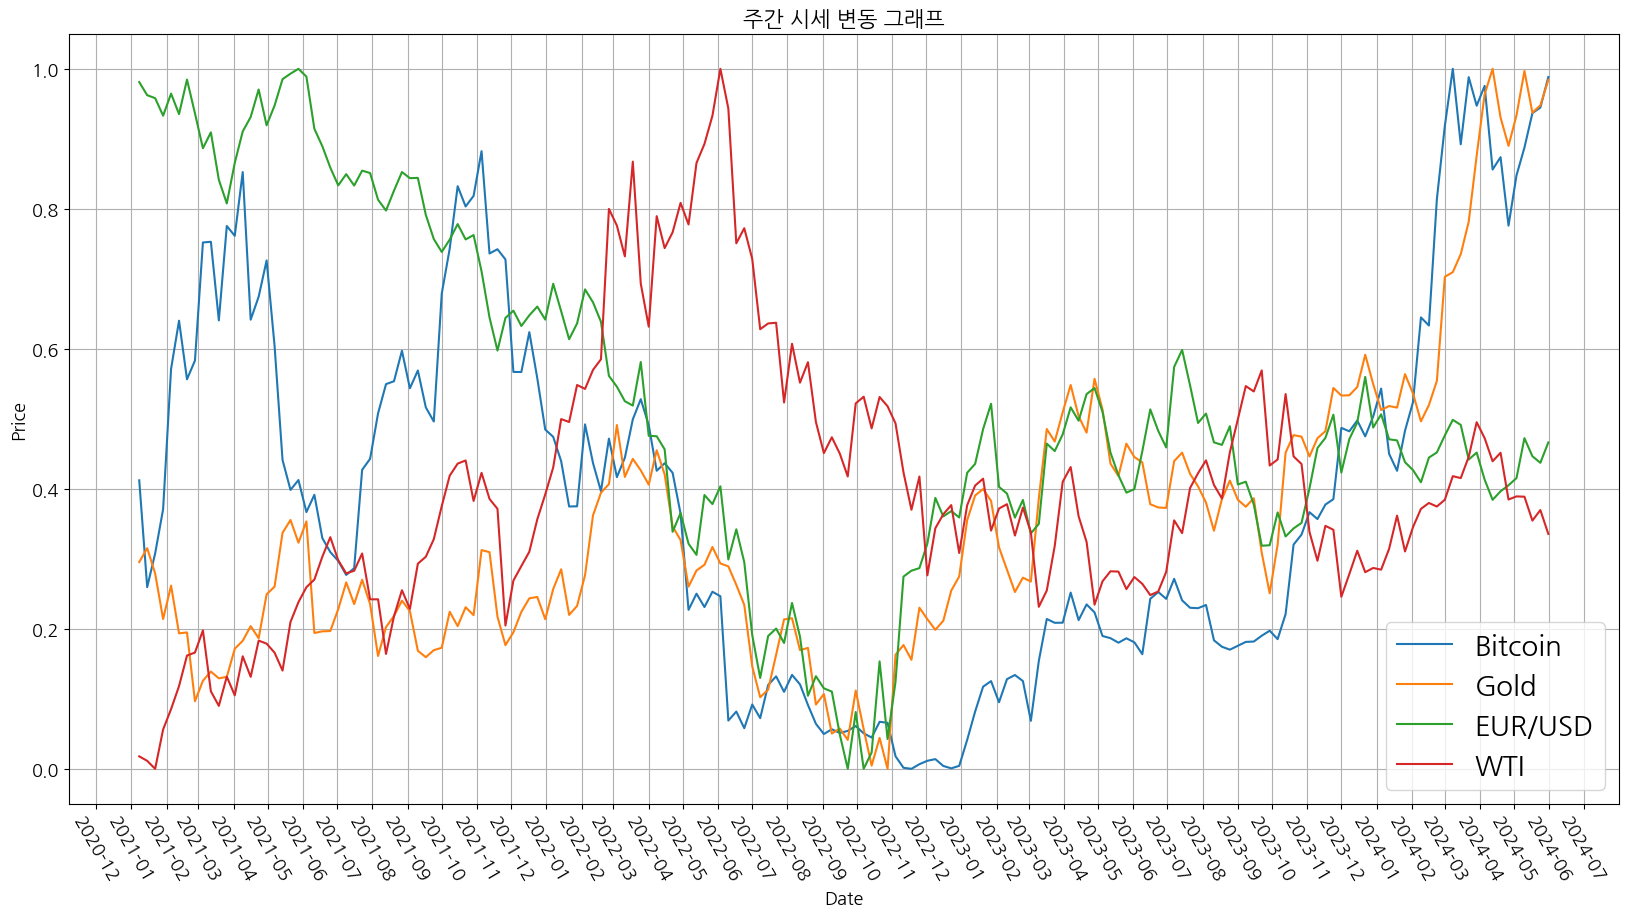

In [7]:
# weekly price change graph
y1_wk = ticker_data_wk(bitcoin, start_date, end_date)["Adj Close"]
y2_wk = ticker_data_wk(gold, start_date, end_date)["Adj Close"]
y3_wk = ticker_data_wk(usd, start_date, end_date)["Adj Close"]
y4_wk = ticker_data_wk(wti, start_date, end_date)["Adj Close"]

# 스케일링할 데이터 모양 변경
y1 = y1_wk.values.reshape(-1, 1)
y2 = y2_wk.values.reshape(-1, 1)
y3 = y3_wk.values.reshape(-1, 1)
y4 = y4_wk.values.reshape(-1, 1)

dates = y1_wk.index # 날짜 추출

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (20, 10))
plt.plot(y1_wk.index, scaler.fit_transform(y1), label = "Bitcoin")
plt.plot(y2_wk.index, scaler.fit_transform(y2), label = "Gold")
plt.plot(y3_wk.index, scaler.fit_transform(y3), label = "EUR/USD")
plt.plot(y4_wk.index, scaler.fit_transform(y4), label = "WTI")
plt.legend(loc = "best", prop = {"size" : 20})
plt.xlabel("Date")
plt.ylabel("Price")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation = 300)
plt.grid(True)
plt.title("주간 시세 변동 그래프")
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


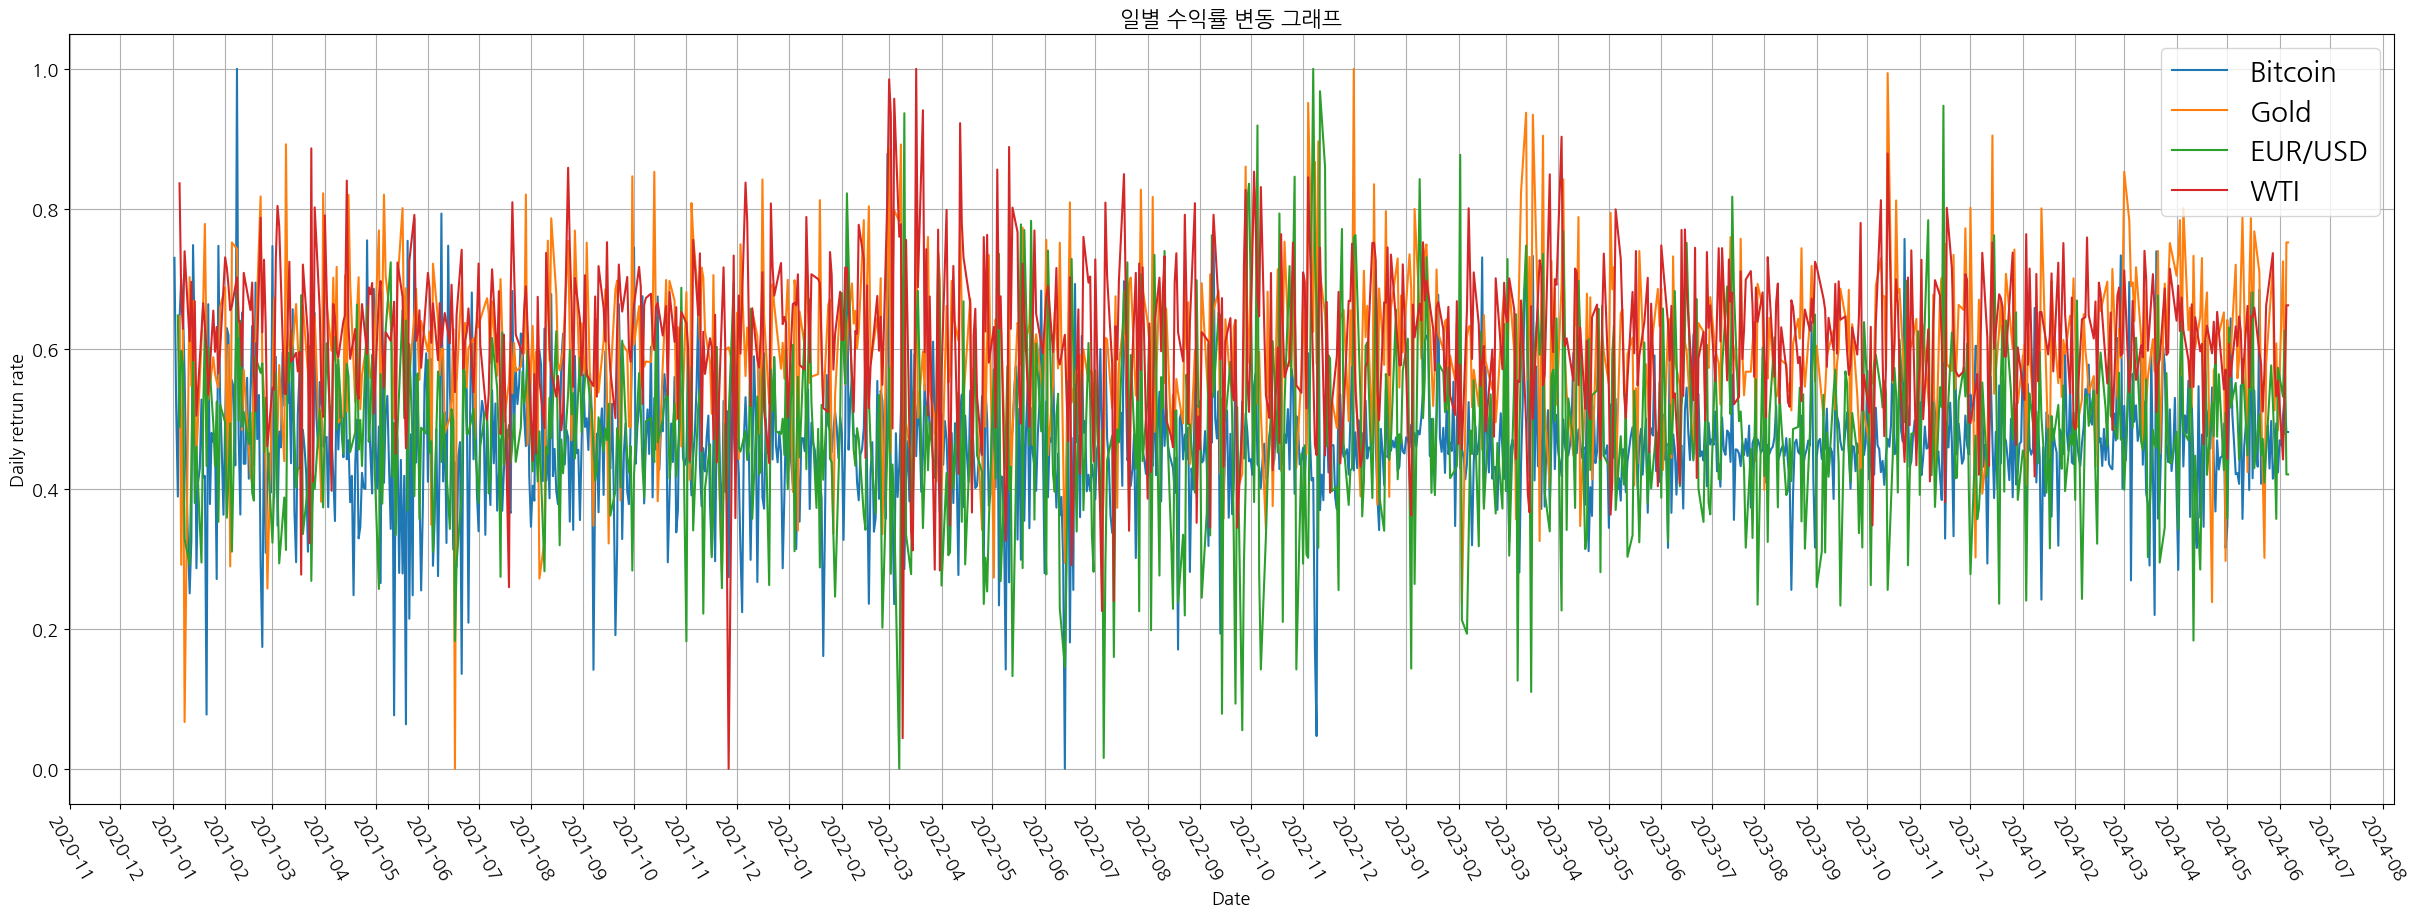

In [8]:
# daily return rate change graph
# 일별 수익률(=증감률)의 변동성 확인
# interpolate() : 결측치 보간
d_y1 = daily_return_rate(bitcoin, start_date, end_date).reindex(all_dates).interpolate()
d_y2 = daily_return_rate(gold, start_date, end_date).reindex(all_dates).interpolate()
d_y3 = daily_return_rate(usd, start_date, end_date).reindex(all_dates).interpolate()
d_y4 = daily_return_rate(wti, start_date, end_date).reindex(all_dates).interpolate()


# 스케일링할 데이터 모양 변경
y1 = d_y1.values.reshape(-1, 1)
y2 = d_y2.values.reshape(-1, 1)
y3 = d_y3.values.reshape(-1, 1)
y4 = d_y4.values.reshape(-1, 1)

dates = d_y1.index # 날짜 추출

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (30, 10))
plt.plot(dates, scaler.fit_transform(y1), label = "Bitcoin")
plt.plot(dates, scaler.fit_transform(y2), label = "Gold")
plt.plot(dates, scaler.fit_transform(y3), label = "EUR/USD")
plt.plot(dates, scaler.fit_transform(y4), label = "WTI")
plt.legend(loc = "best", prop = {"size" : 20})
plt.xlabel("Date")
plt.ylabel("Daily retrun rate")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation = 300)
plt.grid(True)
plt.title("일별 수익률 변동 그래프")
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


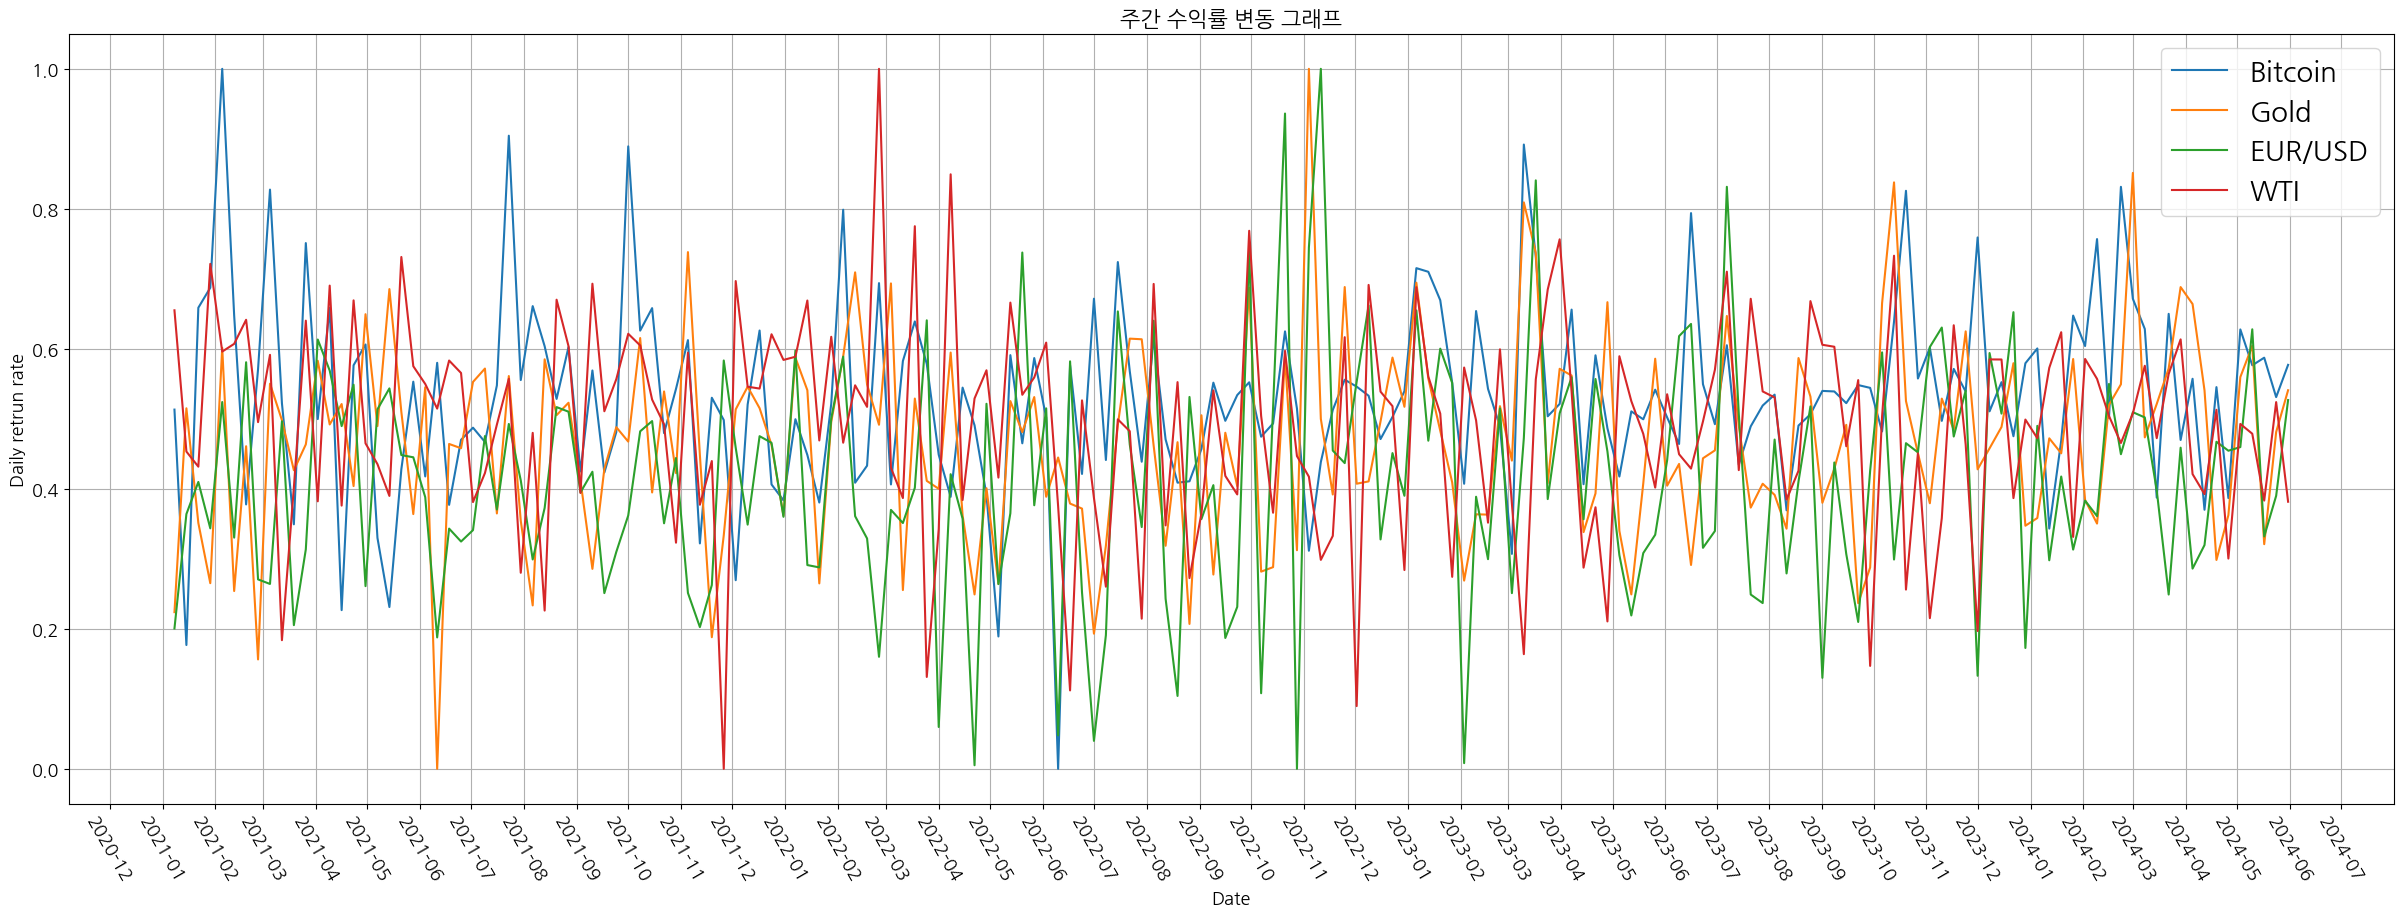

In [9]:
# weekly return rate change graph
# 주간 수익률 (=증감률)의 변동성 확인
# interpolate() : 결측치 보간
w_y1 = weekly_return_rate(bitcoin, start_date, end_date).interpolate()
w_y2 = weekly_return_rate(gold, start_date, end_date).interpolate()
w_y3 = weekly_return_rate(usd, start_date, end_date).interpolate()
w_y4 = weekly_return_rate(wti, start_date, end_date).interpolate()

# 각 데이터의 길이가 일정하지 않아, 하나의 DataFrame으로 병합 후 결측치 제거
concat_data = pd.concat([w_y1, w_y2, w_y3, w_y4], axis = 1).dropna()

# 병합한 DataFrame으로 스케일링
scaled_data = scaler.fit_transform(concat_data)

# Extract scaled data for each column
scaled_y1 = scaled_data[:, 0]  # Bitcoin
scaled_y2 = scaled_data[:, 1]  # Gold
scaled_y3 = scaled_data[:, 2]  # EUR/USD
scaled_y4 = scaled_data[:, 3]  # WTI

dates = concat_data.index # 날짜 추출

plt.figure(figsize=(30, 10))
plt.plot(dates, scaled_y1, label = "Bitcoin")
plt.plot(dates, scaled_y2, label = "Gold")
plt.plot(dates, scaled_y3, label = "EUR/USD")
plt.plot(dates, scaled_y4, label = "WTI")

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.legend(loc = "best", prop = {"size" : 20})
plt.xlabel("Date")
plt.ylabel("Daily retrun rate")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation = 300)
plt.grid(True)
plt.title("주간 수익률 변동 그래프")
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


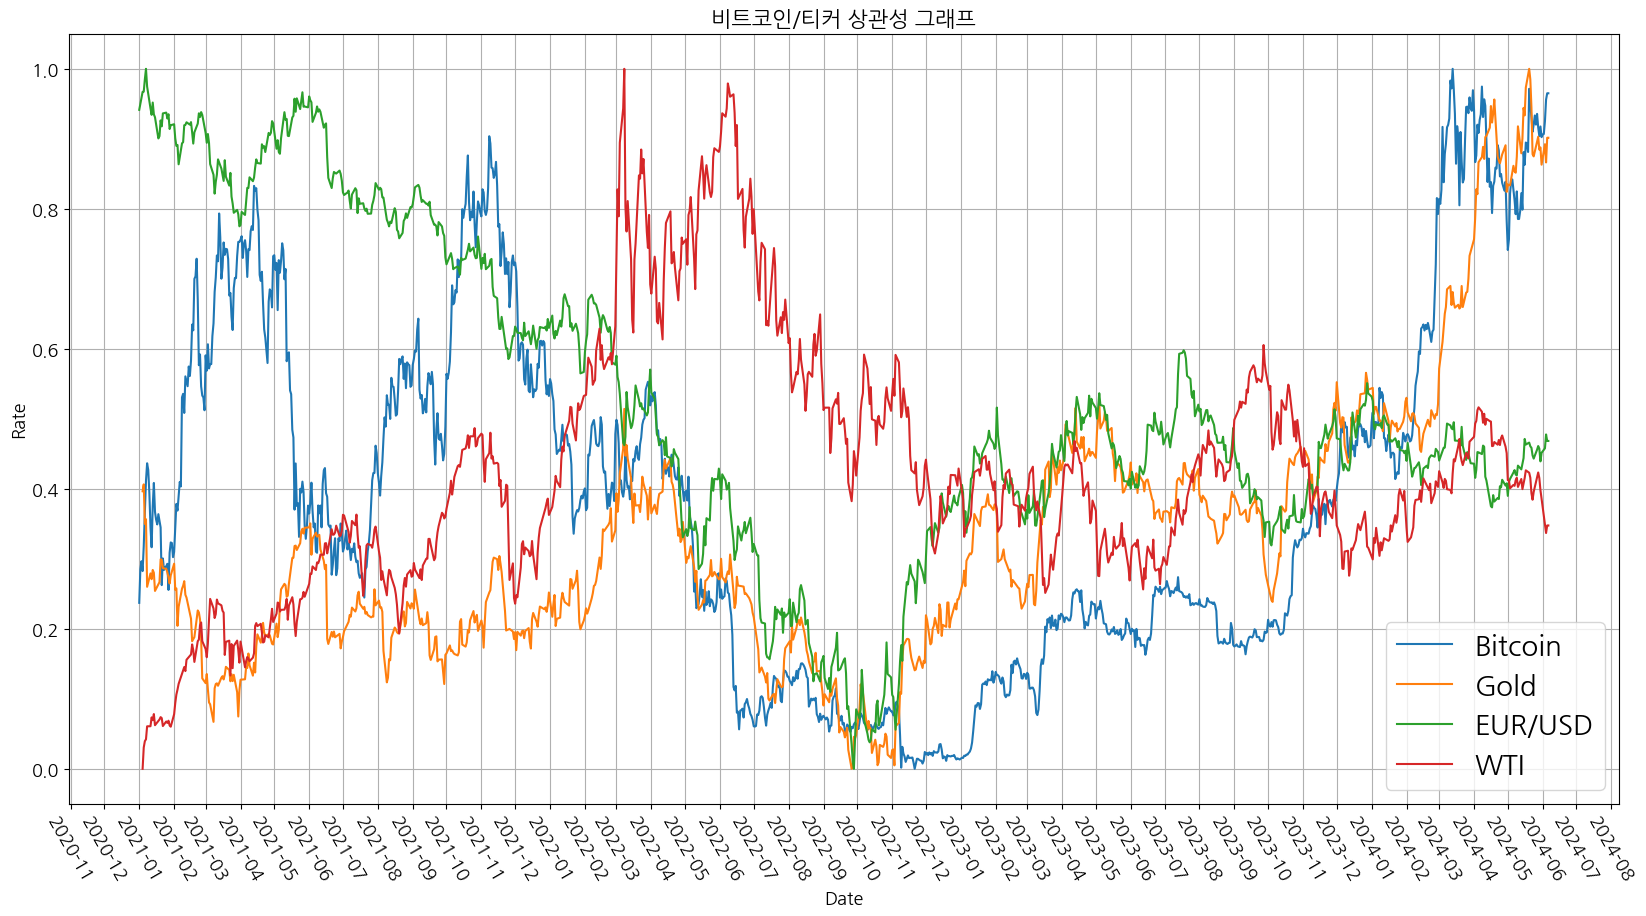

In [10]:
# 상관성 그래프 시각화
# weekly_return_rate(Bitcoin) / weekly_return_rate(ticker)
corr_y1 = corr_bit(bitcoin, start_date, end_date).reindex(all_dates).interpolate()
corr_y2 = corr_bit(gold, start_date, end_date).reindex(all_dates).interpolate()
corr_y3 = corr_bit(usd, start_date, end_date).reindex(all_dates).interpolate()
corr_y4 = corr_bit(wti, start_date, end_date).reindex(all_dates).interpolate()

y1 = y1_series.values.reshape(-1, 1)
y2 = y2_series.values.reshape(-1, 1)
y3 = y3_series.values.reshape(-1, 1)
y4 = y4_series.values.reshape(-1, 1)

dates = corr_y1.index
plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (20, 10))
plt.plot(dates, scaler.fit_transform(y1), label = "Bitcoin")
plt.plot(dates, scaler.fit_transform(y2), label = "Gold")
plt.plot(dates, scaler.fit_transform(y3), label = "EUR/USD")
plt.plot(dates, scaler.fit_transform(y4), label = "WTI")
plt.legend(loc = "best", prop = {"size" : 20})
plt.xlabel("Date")
plt.ylabel("Rate")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation = 300)
plt.grid(True)
plt.title("비트코인/티커 상관성 그래프")
plt.show()

## 피어슨 상관 계수
    - 각 종목들 간 상관 계수 분석
    - 상관 계수의 수치가 0.3 ~ 0.7 이면 상관관계가 있다고 봄 (약함 ~ 중간 정도의 양의 상관관계)

In [11]:
# 비트코인과 티커의 상관 계수 산출
df_close = pd.concat([bit_ticker["Adj Close"], ticker["Adj Close"]], axis = 1)
df_close.columns = ["bit_adj_close", "tk_adj_close"]
df_close = df_close.dropna()
corr_coefficient = np.corrcoef(df_close["bit_adj_close"], df_close["tk_adj_close"])[0, 1]
print(f"비트코인과의 상관 계수 : {corr_coefficient:.4f}")

비트코인과의 상관 계수 : 0.5073


### 🔥 HeatMap 생성

#### ✅ 안전/안정적 자산 비교군 추가
- iShares 20+ Year Treasury Bond ETF : 미국 국채 ETF, 미국의 장기 국채에 투자하여 안정적인 수익을 추구, 종목코드 "TLT"
- iShares iBoxx $ Investment Grade Corporate Bond ETF : 미국 투자등급 회사채에 투자하는 ETF, 종목코드 "LQD"
- Duke Energy : 전력 및 천연가스 서비스를 제공하는 유틸리티 부문 공공 주식, 종목코드 "DUK"
- Gold ETF : 나스닥 100 지수를 추종하는 ETF, 금 가격에 연동되어 금에 투자하는 효과를 제공하는 ETF, 종목코드 "GLD"

#### ✅ 위험 자산 비교군 추가
- Brent oil :  종목코드 "BZ=F"
- Tesla :  종목코드 "TSLA"
- Dow Jones Industrial Average : 다우존스 산업 평균 지수, 주로 대형 기업들로 구성되어 있어, 시장 전체보다는 주로 대형주 및 산업을 대표, 종목코드 "^DJI"
- Nasdaq-100 Index : 나스닥 100 지수를 추종하는 ETF, 종목코드 "QQQ"
- Emerging Markets ETF : 중국, 인도, 브라질 등 신흥 시장의 주식에 투자하는 ETF, 종목코드 "EEM"

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


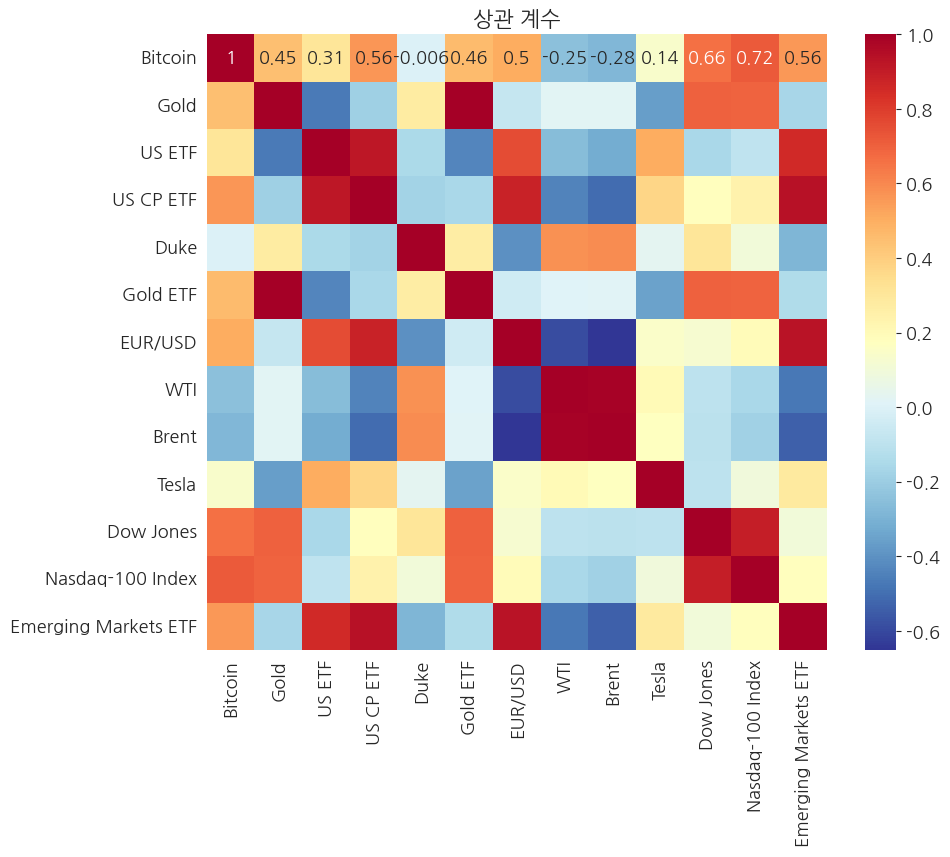

In [12]:
# 상관 계수 시각화 - HeatMep
corr_matrix = pd.DataFrame({"Bitcoin" : daily_adj_close(bitcoin, start_date, end_date),
                            # 안전 자산, 안정적 자산
                            "Gold" : daily_adj_close(gold, start_date, end_date),
                            "US ETF" : daily_adj_close("TLT", start_date, end_date),
                            "US CP ETF" : daily_adj_close("LQD", start_date, end_date),
                            "Duke" : daily_adj_close("DUK", start_date, end_date),
                            "Gold ETF" : daily_adj_close("GLD", start_date, end_date),
                            "EUR/USD" : daily_adj_close(usd, start_date, end_date),
                            # 위험 자산
                            "WTI" : daily_adj_close(wti, start_date, end_date),
                            "Brent" : daily_adj_close("BZ=F", start_date, end_date),
                            "Tesla" : daily_adj_close("TSLA", start_date, end_date),
                            "Dow Jones" : daily_adj_close("^DJI", start_date, end_date),
                            "Nasdaq-100 Index" : daily_adj_close("QQQ", start_date, end_date),
                            "Emerging Markets ETF" : daily_adj_close("EEM", start_date, end_date)}).corr()

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (10, 8))
sns.heatmap(corr_matrix, annot = True, cmap = "RdYlBu_r", cbar = True)
plt.title("상관 계수")
plt.show()

## 뉴스 크롤링
- 티커의 변동성이 큰 날짜와 특정 날짜의 네이버 뉴스 크롤링
- 검색 키워드 : "{티커} 환율/시세/가격 등"

In [13]:
# 주간 티커 데이터 수집
ticker_wk = ticker_data_wk(usd, start_date, end_date)
ticker_wk

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,weekly_return
Date,,,,,,,
2021-01-08,1.226873,1.228215,1.211314,1.216249,1.216249,0,-1.447335
2021-01-15,1.215300,1.217196,1.205545,1.211563,1.211563,0,-0.385283
2021-01-22,1.216619,1.218800,1.206200,1.210507,1.210507,0,-0.087147
2021-01-29,1.212136,1.215701,1.196716,1.204239,1.204239,0,-0.517831
2021-02-05,1.196745,1.215099,1.195357,1.212121,1.212121,0,0.654551
...,...,...,...,...,...,...,...
2024-05-03,1.073307,1.080941,1.072501,1.074691,1.074691,0,0.236438
2024-05-10,1.078516,1.089681,1.076206,1.088981,1.088981,0,1.329638
2024-05-17,1.086779,1.089562,1.081303,1.082520,1.082520,0,-0.593222


In [14]:
# 상승, 하락이 관계 없는 주간 변동성 추출
ticker_chg_abs = (ticker_wk["weekly_return"]).abs()
# 변동성 큰 구간 TOP6
large_chg = ticker_chg_abs.sort_values(ascending = False)
top_chg = large_chg[:6]
top_chg

Date
2022-11-11    3.747401
2022-10-21    3.332367
2022-10-28    2.750005
2022-04-22    2.716884
2023-03-17    2.712166
2023-02-03    2.697177
Name: weekly_return, dtype: float64

In [15]:
# 뉴스 크롤링 날짜 추가
news_date_list = pd.to_datetime(news_date_list, format="%Y.%m.%d").tolist()
top_lst = top_chg.index.to_list()
news_date_list.extend(top_lst)
news_date_list

[Timestamp('2022-03-28 00:00:00'),
 Timestamp('2022-11-14 00:00:00'),
 Timestamp('2023-04-03 00:00:00'),
 Timestamp('2024-01-08 00:00:00'),
 Timestamp('2024-03-25 00:00:00'),
 Timestamp('2024-05-06 00:00:00'),
 Timestamp('2022-11-11 00:00:00'),
 Timestamp('2022-10-21 00:00:00'),
 Timestamp('2022-10-28 00:00:00'),
 Timestamp('2022-04-22 00:00:00'),
 Timestamp('2023-03-17 00:00:00'),
 Timestamp('2023-02-03 00:00:00')]

In [16]:
news_titles = []
search = input("뉴스 검색어 입력 (ex. 달러 환율) : ")

driver = wb.Chrome()
driver.maximize_window()
for i in tqdm(range(len(news_date_list))) :
    # 뉴스 검색 기간 : 지정된 날짜 포함 일주일
    news_ds = news_date_list[i]
    news_de = news_ds + datetime.timedelta(days = 6)
    driver.get(f"https://search.naver.com/search.naver?where=news&query={search}&sm=tab_opt&sort=0&photo=0&field=0&pd=3&ds={news_ds.strftime('%Y.%m.%d')}&de={news_de.strftime('%Y.%m.%d')}&docid=&related=0&mynews=0&office_type=0&office_section_code=0")
    
    body = driver.find_element(By.TAG_NAME, "body")
    try :
        # 스크롤
        for _ in range(10) :
            body.send_keys(Keys.END)
            time.sleep(1)
            
        # 뉴스 타이틀 수집
        titles = driver.find_elements(By.CSS_SELECTOR, "a.news_tit")
        for i in titles :
            news_titles.append(i.text)
    except Exception as e :
        print("오류 : ", e)
print("완료😇")
driver.quit()

100%|██████████| 12/12 [02:28<00:00, 12.35s/it]


완료😇


In [17]:
print(len(news_titles))
print(news_titles)

1160
["美 Fed '빅스텝' 예고…하반기 오히려 달러약세 올 수도", '원/달러 환율 상승세…1,210원대 중후반', "'달러당 124엔' 안전자산 엔화의 추락…日에 무슨 일이[이지경제]", 'TIGER 미국달러단기채권액티브 ETF 순자산 3000억 돌파', '[외환브리핑]달러 약세vs위험 회피…환율, 1200원대 공방 예상', '원달러환율 1209.6원 마감', '우크라 평화협상 진전에 원·달러 환율 10원 급락한 1209.6원', '[오늘의 환율전망] 달러 위험회피성향에 상승… 2원 상승 출발 예상', '원달러 환율 다시 1220원대로(종합)', '원/달러 환율 보합세…1,210원선 등락', '원 달러 환율 상승 마감', '원/달러 환율 2.5원 오른 1,212원에 마감', '이창용 "비둘기파도 매파도 될 수 있다…환율 상승, 물가 자극 우려"', '우크라 협상 기대에 원/달러 환율 1,220원 밑으로', '[환율마감] 원/달러 환율, 3.4원 오른 1215.5원', '우크라 협상진전에 원/달러 환율 급락…1,210원대 초반', '원달러 환율 1210원 초반 등락', '[외환브리핑]달러 약세vs위험 회피…환율, 1200원대 공방 예상', '원/달러 환율, 장 초반 하락세…1,220원대 초반', '[시황]코스피 2757.65(▲0.40%), 코스닥 944.53(▲0.58%), 원·달러 환율 121...', '러-우 휴전 가능성에…원달러 환율 1210원대', '원·달러 환율 3.1원 오른 1215.2원 출발', '4월 국내 LPG 공급가 kg당 140원 인상…"유가-환율 상승 영향"', '고착화되는 엔저…실효환율에서 드러나는 일본의 쇠락', '<뉴욕마켓워치> 견조한 3월 비농업 고용…주식·달러↑채권 혼조', '코스피 하락 환율 상승 마감', '원달러 환율 2거래일 연속 1220원대 지속', '원/달러 환율 장 초반 상승세…1,220원대', '신한은행, 삼성證 해외주식계좌 첫 연결 고객 대상 달러 지급 이벤트', '[환율전망] 원ㆍ달러 환율, 12원 하락 

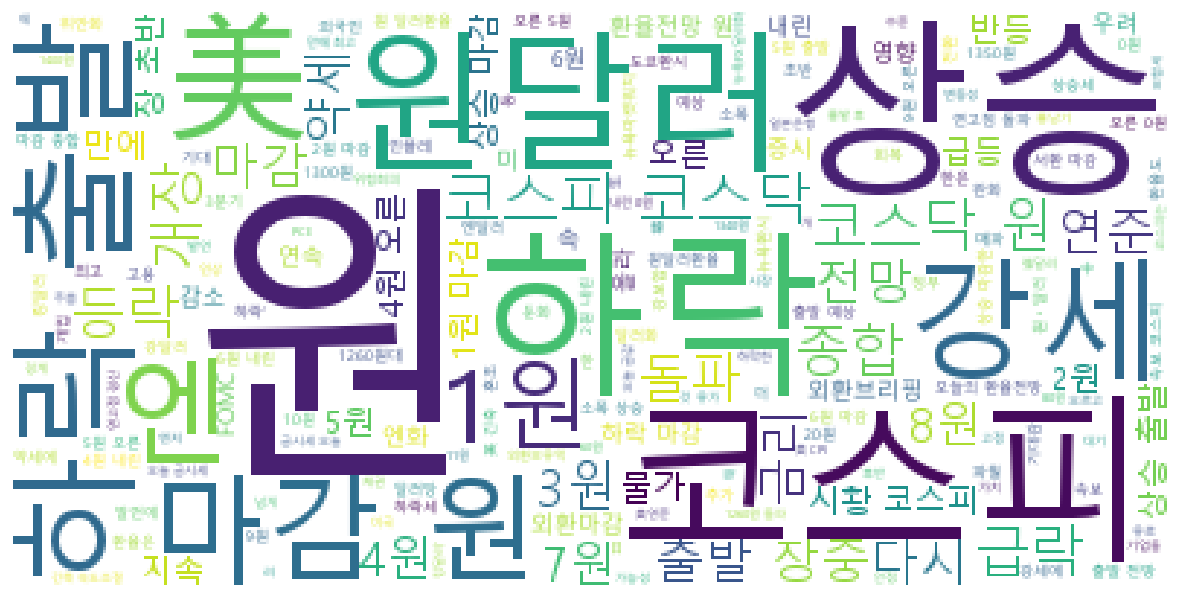

In [19]:
# 워드클라우드를 통한 핵심 키워드 시각화
text = ",".join(news_titles)
f_path = "C:\Windows\Fonts\malgun.ttf"

wc = WordCloud(font_path = f_path, random_state = 42, background_color = "white")
wc.generate(text)
plt.figure(figsize = (15, 10))
plt.axis("off")
plt.imshow(wc, interpolation = "None")
plt.show()